# 支持向量机（SVM）

分类学习最基本的想法就是基于训练集D在样本空间中找到一个划分超平面，将不同类别的样本分开并选择泛化能力最强的划分超平面。划分超平面可通过如下线性方程描述，其中 $W=(w_1;w_2;…;w_d)$为法向量，决定了超平面的方向，b为位移项，决定了超平面与原点之间的距离。
一个超平面可以表示为：
$$\boldsymbol{w}^T\boldsymbol{x}+b=0$$

## 一个示例

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

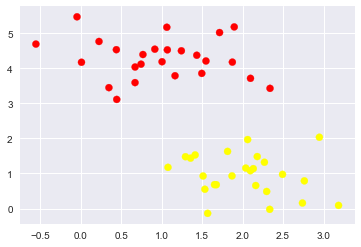

In [13]:
#随机来点数据
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

* 要使这两类数据分开，有很多种分割法，随便的画几条分割线，哪个更好呢？

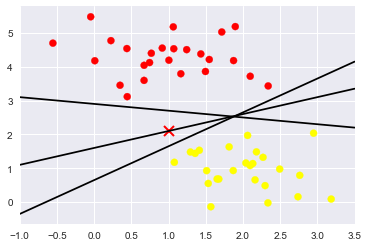

In [16]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([1], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3.5);

* 可以看出中间的那条分割线从感觉上相较于其他两条更好些，为什么呢？

## 核心思想：最大化间隔
* 目标：找到一条距离两类间隔最大一个划分超平面
![](./img/1.PNG)

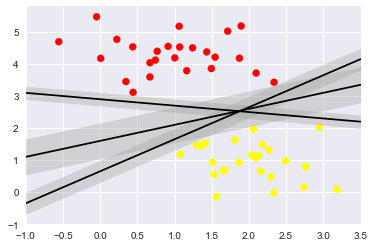

In [18]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)
plt.xlim(-1, 3.5);

![](./img/2.jpg)SVM基本型：![](./img/3.png)

[计算流程](https://www.cnblogs.com/steven-yang/p/5658362.html)

## 训练一个基本的SVM

In [19]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear')
model.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
?SVC#查看SVC的基本函数接口

In [20]:
#绘图函数
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

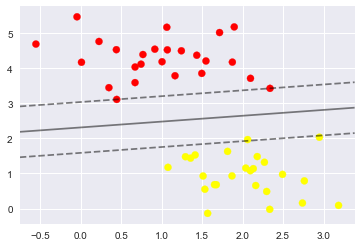

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

* 这条线就是我们希望得到的决策边界啦

* 观察发现有3个点做了特殊的标记，它们恰好都是边界上的点

* 它们就是我们的*support vectors*（支持向量）

* 在Scikit-Learn中, 它们存储在这个位置 ``support_vectors_``（一个属性）

In [22]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

## [核函数](https://blog.csdn.net/cqy_chen/article/details/77932270)
在这章之前，我们都假设样本是线性可分的，即存在一个划分超平面可以将训练样本正确分类，然而现实中有很多不是能线性分类的，例如：

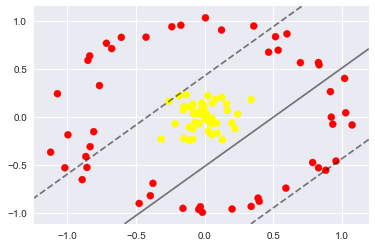

In [27]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

对于这样的问题，我们可以将样本从原始空间映射到一个更高维度的特征空间，使得样本在这个特征空间内线性可分。

比如：二维下的一个点<x1,x2><x1,x2>, 可以映射到一个5维空间，这个空间的5个维度分别是:x1,x2,x1x2,x12,x22x1,x2,x1x2,x12,x22。
映射到高维度，有两个问题：一个是如何映射？另外一个问题是计算变得更复杂了。

幸运的是我们可以使用核函数(Kernel function)来解决这个问题。
核函数(kernel function)也称为核技巧(kernel trick)。
核函数的思想是：给出了任意两个样本之间关系的度量。

![](./img/6.png)

常用核函数：
![](./img/5.PNG)

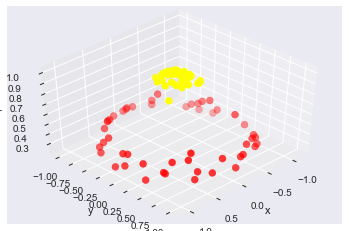

In [28]:
#加入了新的维度r
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D(elev=45, azim=45, X=X, y=y)

* 这样看起来是不是就好分割了呢?

In [44]:
#加入径向基函数
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

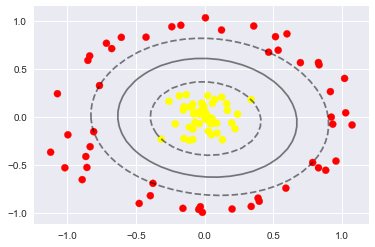

In [45]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)

* 使用这种核支持向量机，我们学习一个合适的非线性决策边界。这种核变换策略在机器学习中经常被使用！

## 调节SVM参数: Soft Margin问题
![](./img/7.PNG)
![](./img/8.PNG)

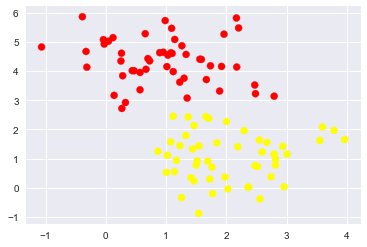

In [48]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

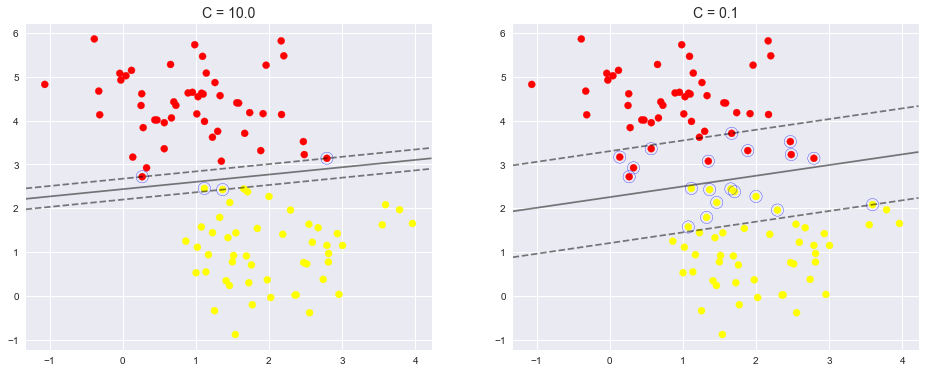

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],s=150,marker='o',c='',edgecolors='blue')#画支持向量
    axi.set_title('C = {0:.1f}'.format(C), size=14)

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [82]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

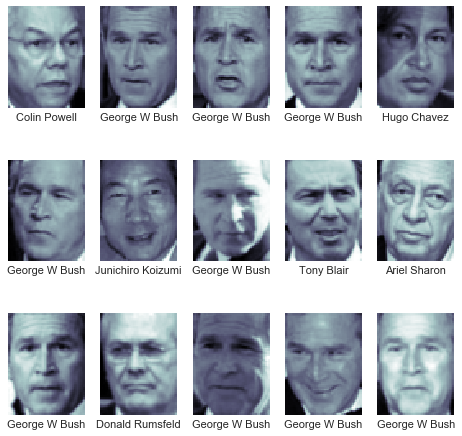

In [95]:
fig, ax = plt.subplots(3, 5,figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

* 每个图的大小是 [62×47]
* 在这里我们就把每一个像素点当成了一个特征，但是这样特征太多了，用PCA降维（后面讲降维算法会具体讲）一下吧！

In [103]:
from sklearn.svm import SVC
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
#make_pipeline():
pca = PCA(n_components=150, whiten=True, random_state=42)#压缩成159维的特征
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [104]:
? make_pipeline

In [109]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)
print(Xtrain[:2])

[[107.333336 107.333336 108.666664 ... 109.        96.333336  99.      ]
 [ 90.666664  63.        57.666668 ... 216.33333  218.       218.      ]]


* 使用grid search cross-validation来选择我们的参数

In [110]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0001, 0.0005, 0.001]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 23.7 s
{'svc__C': 10, 'svc__gamma': 0.001}


In [111]:
model = grid.best_estimator_
yfit = model.predict(Xtest)
yfit.shape

(337,)

* 看看咋样吧！

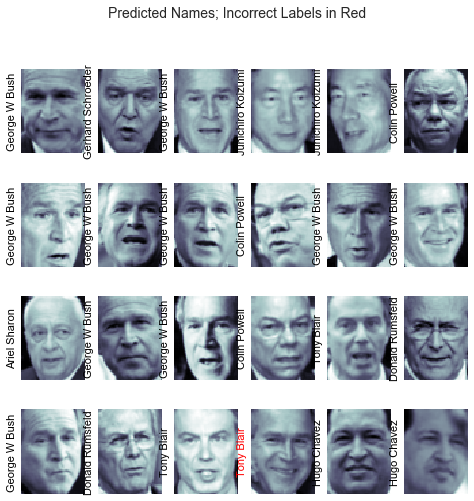

In [114]:
fig, ax = plt.subplots(4, 6,figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [122]:
# 分类结果汇报
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

      avg / total       0.86      0.85      0.85       337



* 精度(precision) = 正确预测的个数(TP)/被预测正确的个数(TP+FP)
* 召回率(recall)=正确预测的个数(TP)/真实情况是正例的个数(TP+FN)
* F1 = 2\*精度\*召回率/(精度+召回率)

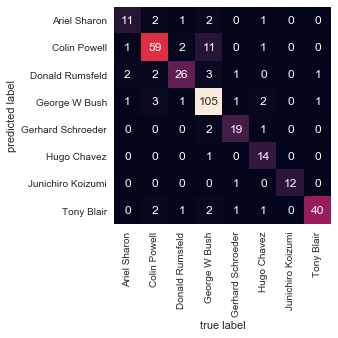

In [128]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## [支持向量回归](https://www.cnblogs.com/nolonely/p/6677276.html)
对于一般的回归问题，给定训练样本D={(x1,y1),(x2,y2),...,(xn,yn)},yi€R,我们希望学习到一个f（x）使得，其与y尽可能的接近，w，b是待确定的参数。在这个模型中，只有当发f(x)与y完全相同时，损失才为零，而支持向量回归假设我们能容忍的f(x)与之间最多有ε的偏差，当且仅当f(x)与y的差别绝对值大于ε时，才计算损失，此时相当于以f(x)为中心，构建一个宽度为2ε的间隔带，若训练样本落入此间隔带，则认为是被预测正确的。
![](./img/9.png)

## Example:使用SVR 预测波士顿地区房价

In [130]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

In [131]:
# 1 准备数据
# 读取波士顿地区房价信息
boston = load_boston()
# 查看数据描述
print(boston.DESCR)   # 共506条波士顿地区房价信息，每条13项数值特征描述和目标房价
x = boston.data
y = boston.target

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [132]:
# 2 分割训练数据和测试数据
# 随机采样25%作为测试 75%作为训练
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [133]:
# 3 训练数据和测试数据进行标准化处理
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

y_train = scale.fit_transform(y_train.reshape(-1, 1))
y_test = scale.transform(y_test.reshape(-1, 1))

In [138]:
# 4.1 支持向量机模型进行学习和预测
# 线性核函数配置支持向量机
linear_svr = SVR(kernel="linear")
# 训练
linear_svr.fit(x_train,y_train.ravel())
# 预测 保存预测结果
linear_svr_y_predict = linear_svr.predict(x_test)

In [142]:
# 5 模型评估
# 线性核函数 模型评估
print("线性核函数支持向量机的默认评估值为：", linear_svr.score(x_test, y_test))
print("线性核函数支持向量机的R_squared值为：", r2_score(y_test, linear_svr_y_predict))
print("线性核函数支持向量机的均方误差为:", mean_squared_error(scale.inverse_transform(y_test),
                                              scale.inverse_transform(linear_svr_y_predict)))
print("线性核函数支持向量机的平均绝对误差为:", mean_absolute_error(scale.inverse_transform(y_test),
                                                 scale.inverse_transform(linear_svr_y_predict)))

线性核函数支持向量机的默认评估值为： 0.6223761624972501
线性核函数支持向量机的R_squared值为： 0.6223761624972501
线性核函数支持向量机的均方误差为: 26.44391871608831
线性核函数支持向量机的平均绝对误差为: 3.078944880480365
